### OpenCV

In [1]:
!wget https://raw.githubusercontent.com/Hu-Bots/SIFT_TUTORIAL/main/mario_query.jpeg
!wget https://raw.githubusercontent.com/Hu-Bots/SIFT_TUTORIAL/main/mario_train.jpeg

--2022-10-14 17:53:30--  https://raw.githubusercontent.com/Hu-Bots/SIFT_TUTORIAL/main/mario_query.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8497 (8.3K) [image/jpeg]
Saving to: ‘mario_query.jpeg.1’

mario_query.jpeg.1  100%[===================>]   8.30K  --.-KB/s    in 0.002s  

2022-10-14 17:53:31 (4.04 MB/s) - ‘mario_query.jpeg.1’ saved [8497/8497]

--2022-10-14 17:53:31--  https://raw.githubusercontent.com/Hu-Bots/SIFT_TUTORIAL/main/mario_train.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

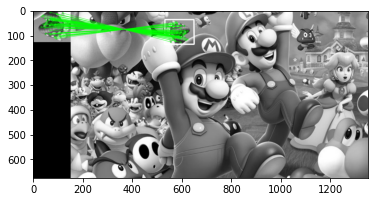

(<matplotlib.image.AxesImage at 0x13d9aa610>, None)

In [3]:

img1 = cv.imread('mario_query.jpeg',0) # queryImage
img2 = cv.imread('mario_train.jpeg',0) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kps_img = cv.drawKeypoints(
    image     = img2,
    keypoints = kp2,
    outImage  = img2
)

# matching algorythm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2) #(tuple with matches)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M) # 4 coordinates

    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(
                   matchColor       = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask      = matchesMask, # draw only inliers
                   flags            = 2
                   )

img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

In [31]:
from typing import List

def get_2d_gaussian(size: List[int], fwhm: float = 3, center: List[float] = None):
    x = np.expand_dims(np.arange(0, size[0], 1), axis=1)
    y = np.expand_dims(np.arange(0, size[1], 1), axis=0)

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[1]
        y0 = center[0]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def get_2d_mix_gaussian(size: List[int], fwhm_list: List[float], center_list = List[List[float]]):
    mix_gaussian = 0
    for fwhm, center in zip(fwhm_list, center_list):
        mix_gaussian += get_2d_gaussian(size, fwhm, center)
    return mix_gaussian

In [19]:
center_list = [kp2[m.trainIdx].pt for m in good]
radius_list = [kp2[m.trainIdx].size for m in good]

In [30]:
center_list

[(471.9530334472656, 84.39384460449219),
 (471.2265319824219, 117.02677917480469),
 (465.92333984375, 121.00916290283203),
 (465.88018798828125, 92.9740219116211),
 (462.3590087890625, 87.92406463623047),
 (461.3963623046875, 81.86621856689453),
 (460.2149353027344, 110.58458709716797),
 (459.64007568359375, 93.28430938720703),
 (458.9027099609375, 97.01261901855469),
 (458.4539489746094, 63.55964660644531),
 (454.92572021484375, 100.40990447998047),
 (451.9750061035156, 105.0359115600586),
 (445.4573669433594, 89.10128021240234),
 (445.4573669433594, 89.10128021240234),
 (445.0660705566406, 74.07837677001953),
 (444.5943603515625, 109.67877960205078),
 (444.5943603515625, 109.67877960205078),
 (444.077392578125, 61.95558547973633),
 (444.077392578125, 61.95558547973633),
 (444.077392578125, 61.95558547973633),
 (443.8379211425781, 129.58091735839844),
 (441.2781982421875, 113.69985961914062),
 (440.3244934082031, 93.69383239746094),
 (439.4168701171875, 106.44749450683594),
 (437.9983

In [32]:
tmp = get_2d_mix_gaussian(size=(675, 1200), fwhm_list=radius_list, center_list=center_list)

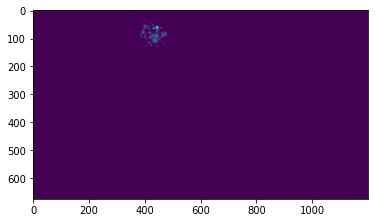

In [33]:
plt.imshow(tmp)